<h1>Image Extraction from LifFile</h1>

In [11]:
import numpy as np
from readlif.reader import LifFile
from matplotlib import pyplot as plt
import skimage
from skimage.filters import threshold_otsu, threshold_isodata
from skimage.exposure import adjust_gamma
import pandas as pd
import napari
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle


import preprocessing_old as preprocessing
import segmentation_old as segmentation

<h1>Segmentation</h1>

<h4>Max-Z-Projection</h4>

In [12]:
Preprocessor = preprocessing.Preprocessor(channel_map=['dapi'])
Segmenter = segmentation.Segmenter()

In [13]:
images = Segmenter.load_images('images/JC_Plate1_both_high/gamma_adjusted', '')
images = [{'dapi': img['image'], 'filename': img['filename']} for img in images]
images

[{'dapi': array([[[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]],
  
         [[0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        , ..., 2.2126

In [14]:
#example for single channel non-serial use of the function
max_z2 = Preprocessor.project_max_z(images,'numpy', ['dapi'])


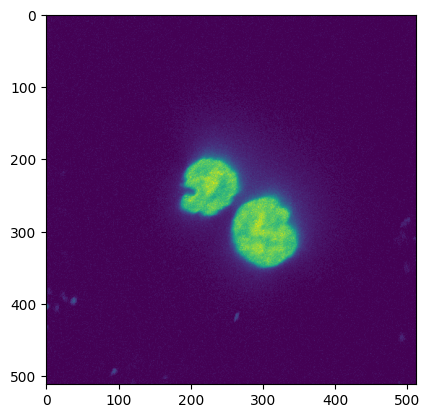

In [15]:
plt.imshow(max_z2[2]['dapi_max_z'])

<h4>Thresholding for background detection</h4>

In [16]:
Segmenter = segmentation.Segmenter()
images = Segmenter.apply_threshold(images)

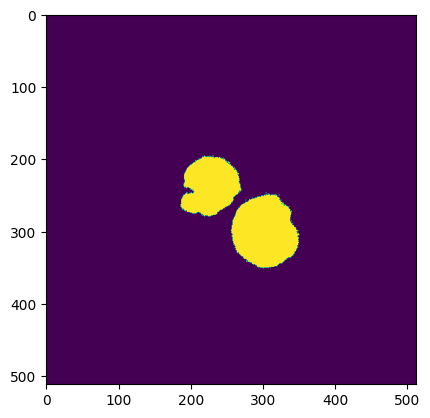

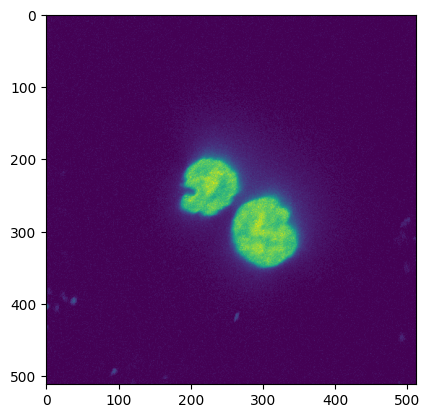

In [17]:
plt.imshow(images[2]['2d_mask'])
plt.show()
plt.imshow(images[2]['dapi_max_z'])
plt.show()



In [18]:
#images = Segmenter.open_close_img(images)
#plt.imshow(images[2]['2d_mask'])

<h4>Labeling cells, extracting nuclei and removing touching cells + artifacts</h4>

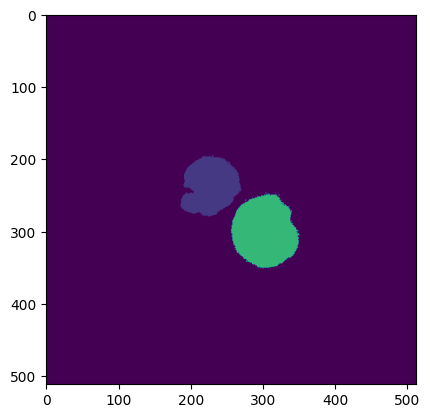

In [19]:
#label foreground of thresholding
images = Segmenter.label_segments_2d(images)
plt.imshow(images[2]['2d_mask'])

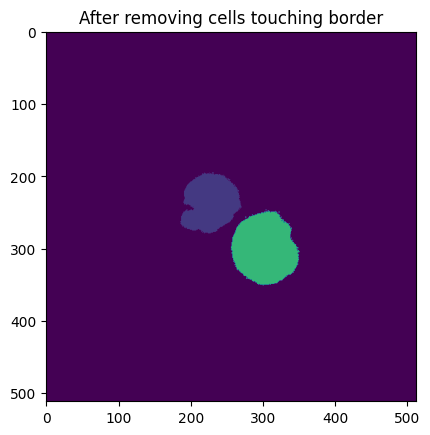

In [20]:
#removing cells touching border
images = Segmenter.remove_border_cells(images)

plt.imshow(images[2]['2d_mask'])
plt.title('After removing cells touching border')
plt.show()

In [21]:
#extract properties of labeled regions
images = Segmenter.extract_nuclei(images)
images[2]['nuclei']


accessible properties for each region: area, region.bbox, region.region.bbox_area, centroid, convex_area, convex_image, coords, eccentricity, equivalent_diameter, euler_number, extent, filled_area, filled_image, image, inertia_tensor, inertia_tensor_eigvals, intensity_image, label, local_centroid, major_axis_length, max_intensity, mean_intensity, min_intensity, minor_axis_length, moments, moments_central, moments_hu, moments_normalized, orientation, perimeter, solidity, weighted_centroid, weighted_local_centroid, weighted_moments, weighted_moments_central, weighted_moments_hu, weighted_moments_normalized

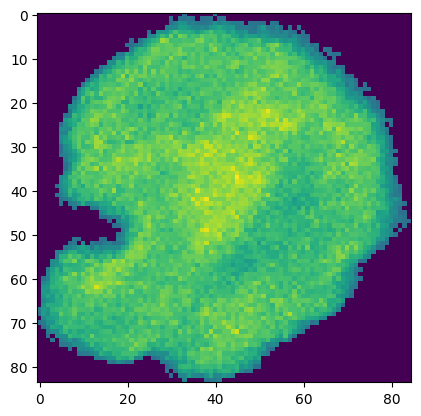

In [22]:
plt.imshow(images[2]['nuclei'][0].intensity_image)

Text(0, 0.5, 'Count')

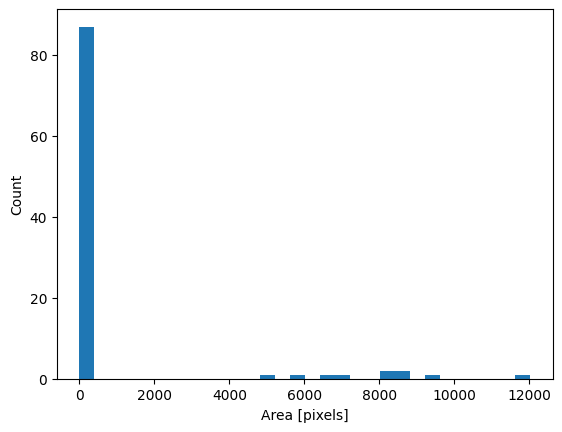

In [23]:
#visualize histogram of region sizes

area_dist = []
for img in images:
    for region in img['nuclei']:
        area_dist.append(region.area)

plt.hist(area_dist, bins=30)
plt.xlabel('Area [pixels]')
plt.ylabel('Count')

In [24]:
#remove by size
upper = 7000
lower = 1500

images = Segmenter.filter_nuclei_2d(images, upper, lower)

In [25]:
columns=[prop for prop in dir(images[2]['nuclei'][0]) if prop[0] != '_']

data = []
for img in images:
    for region in img['nuclei']:       
        data.append([region.__getattribute__(prop) for prop in columns])

len(data)

3

In [26]:
df = pd.DataFrame(data=data, columns=columns)
df

,area,area_bbox,area_convex,area_filled,axis_major_length,axis_minor_length,bbox,centroid,centroid_local,centroid_weighted,...,moments_weighted,moments_weighted_central,moments_weighted_hu,moments_weighted_normalized,num_pixels,orientation,perimeter,perimeter_crofton,slice,solidity
0,5102.0,7140.0,5462.0,5102.0,87.818986,76.049522,"(196, 186, 280, 271)","(237.62779302234418, 226.62602900823205)","[41.62779302234418, 40.62602900823207]","(237.4482664942986, 226.53288681854548)",...,"[[170873.6031194539, 6926000.415517887, 345498...","[[170873.6031194539, 3.590136744761695e-10, 64...","[0.004652052145705394, 4.272279848550497e-07, ...","[[nan, nan, 0.0022182364063728735, 5.974883503...",5102,-0.658366,338.368578,350.335464,"(slice(196, 280, None), slice(186, 271, None))",0.934090
1,6738.0,10044.0,7236.0,6739.0,108.371812,82.185943,"(175, 194, 283, 287)","(230.29786286731968, 241.6124962897002)","[55.29786286731968, 47.61249628970021]","(230.16355375118715, 241.23364461705455)",...,"[[204094.75753385338, 9640139.245557949, 54246...","[[204094.75753385338, -2.3003803590615498e-09,...","[0.005283622331984262, 1.8162625393962298e-06,...","[[nan, nan, 0.0020915294223624145, -1.83629122...",6738,-0.341561,378.723917,381.133442,"(slice(175, 283, None), slice(194, 287, None))",0.931177
2,5834.0,7830.0,6016.0,5834.0,94.734669,78.554140,"(234, 287, 324, 374)","(277.6602673980117, 329.93143640726777)","[43.660267398011655, 42.93143640726774]","(277.3969734353077, 330.1523456817951)",...,"[[172945.14375890858, 7462988.627472174, 39752...","[[172945.14375890858, -2.559992017219695e-09, ...","[0.0052149926271942, 8.110652796294887e-07, 2....","[[nan, nan, 0.0025236458772511785, 5.060717946...",5834,-0.656733,313.877200,310.723885,"(slice(234, 324, None), slice(287, 374, None))",0.969747


In [27]:
for j, img in enumerate(images):

    images[j]['nuclei_3d'] = []
    images[j]['nuclei_3d_guide_masks'] = []

    for region in images[j]['nuclei']:
        region_img = np.zeros((len(images[j]['dapi']), region.bbox[2] - region.bbox[0], region.bbox[3] - region.bbox[1]), dtype=np.uint8)
        region_guide_mask = np.zeros_like(region_img)
        for i, stack in enumerate(images[j]['dapi']):
            region_img[i] = stack[region.bbox[0]:region.bbox[2], region.bbox[1]:region.bbox[3]]
            region_guide_mask[i] = region.image
        images[j]['nuclei_3d'].append(region_img)
        images[j]['nuclei_3d_guide_masks'].append(region_guide_mask)



In [28]:
from skimage.segmentation import morphological_chan_vese
from tqdm.notebook import tqdm

In [30]:
for i, img in tqdm(enumerate(images)):
    for j in tqdm(range(len(img['nuclei_3d']))):
        Segmenter.save_image(morphological_chan_vese(img['nuclei_3d'][j],300, img['nuclei_3d_guide_masks'][j],1 ,1, 2), str(i) + '_' + str(j), 'images/JC_Plate1_both_high/chan_vese/')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2_0 saved at c:\Users\dario\OneDrive\Dokumente\FHNW\Bachelorarbeit\code\chromatin_imaging\segmentation_comparison\images/JC_Plate1_both_high/chan_vese/2_0.tiff


  0%|          | 0/2 [00:00<?, ?it/s]

3_0 saved at c:\Users\dario\OneDrive\Dokumente\FHNW\Bachelorarbeit\code\chromatin_imaging\segmentation_comparison\images/JC_Plate1_both_high/chan_vese/3_0.tiff
3_1 saved at c:\Users\dario\OneDrive\Dokumente\FHNW\Bachelorarbeit\code\chromatin_imaging\segmentation_comparison\images/JC_Plate1_both_high/chan_vese/3_1.tiff


In [31]:
test = morphological_chan_vese(images[2]['nuclei_3d'][0],300, images[2]['nuclei_3d_guide_masks'][0],1 ,1, 2)

In [36]:
import os

import matplotlib.image as mpimg

# Assuming 'img' is your 3D numpy array and already available in your workspace
# If not, please load or define your 'img' array accordingly.

# Create the directory if it doesn't exist
output_dir = "mask_slices"
os.makedirs(output_dir, exist_ok=True)

# Specify the z-slices you want to save
z_slices = [6, 9, 12, 15]

for z in z_slices:
    # Create the file path
    file_path = os.path.join(output_dir, f'Chanvese_{z}.png')
    
    # Save the image slice directly
    mpimg.imsave(file_path, test[z], cmap='viridis')


In [38]:
import os

import matplotlib.image as mpimg

# Create the directory if it doesn't exist
output_dir = "mask_slices"
os.makedirs(output_dir, exist_ok=True)

# Specify the z-slices you want to save
z_slices = [6, 9, 12, 15]

for z in z_slices:
    # Create the file path
    file_path = os.path.join(output_dir, f'Dapi_{z}.png')
    
    # Save the image slice directly
    mpimg.imsave(file_path, images[2]['dapi'][z], cmap='viridis')
